In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam


In [2]:
def extract_and_save_frames(dataset_path, output_base_dir, frame_count=30):
    categories = ['Normal', 'Violence']  # Exclude 'Weaponized'
    phases = ['Train', 'Test']
    for phase in phases:
        for category in categories:
            video_dir = os.path.join(dataset_path, phase, category)
            output_dir = os.path.join(output_base_dir, phase, category)
            os.makedirs(output_dir, exist_ok=True)
            videos = [os.path.join(video_dir, f) for f in os.listdir(video_dir) if f.endswith('.avi')]
            for video_path in videos:
                video_basename = os.path.splitext(os.path.basename(video_path))[0]
                video_frame_dir = os.path.join(output_dir, video_basename)
                os.makedirs(video_frame_dir, exist_ok=True)
                video = cv2.VideoCapture(video_path)
                count = 0
                try:
                    while count < frame_count:
                        ret, frame = video.read()
                        if not ret:
                            break
                        frame = cv2.resize(frame, (224, 224))
                        frame_filename = f"{video_frame_dir}/{count}.png"
                        cv2.imwrite(frame_filename, frame)
                        count += 1
                finally:
                    video.release()


In [3]:
def build_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the convolutional layers
    for layer in base_model.layers:
        layer.trainable = False  

    # Compile the model with the corrected optimizer parameter
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [4]:
def create_datagen(base_dir):
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    train_generator = train_datagen.flow_from_directory(
        os.path.join(base_dir, 'Train'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        os.path.join(base_dir, 'Test'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

    return train_generator, validation_generator


In [5]:
def train_model(model, train_generator, validation_generator, epochs=10):
    history = model.fit(train_generator,
                        epochs=epochs,
                        validation_data=validation_generator)
    
    # Plotting training results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

    return model


In [6]:
def evaluate_model(model, validation_generator):
    predictions = model.predict(validation_generator)
    y_pred = (predictions > 0.5).astype(int)
    y_true = validation_generator.classes
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:\n', cm)


In [7]:
import re

def sort_frames(file):
    # This regular expression finds numbers in a string and returns the first occurrence.
    # If no number is found, it returns -1 to keep the sorting consistent.
    numbers = re.findall(r'\d+', file)
    return int(numbers[0]) if numbers else -1

def detect_violence(model, video_path):
    temp_dir = r'C:\Users\malak\OneDrive\Documents\Image Processing Project\kaggle\working\temp_frames'
    # Extract frames from the specified video
    extract_and_save_frames(video_path, temp_dir)
    frames = []
    # Sort files based on numeric value found in the filename
    frame_files = sorted(os.listdir(temp_dir), key=sort_frames)
    for frame_file in frame_files:
        img_path = os.path.join(temp_dir, frame_file)
        frame = cv2.imread(img_path)
        frame = preprocess_input(frame)
        frames.append(frame)
    
    if not frames:
        return "No frames extracted, cannot determine content."
    
    frames = np.array(frames)
    predictions = model.predict(frames)
    violence_probability = np.mean(predictions)
    return 'Violent' if violence_probability > 0.5 else 'Non-violent'


In [8]:
# Setup paths and directories
dataset_base_path = r'C:\Users\malak\OneDrive\Documents\Image Processing Project\SCVD - Copy\SCVD_converted'
output_base_dir = r'C:\Users\malak\OneDrive\Documents\Image Processing Project\out'
extract_and_save_frames(dataset_base_path, output_base_dir)

Found 630 images belonging to 2 classes.
Found 270 images belonging to 2 classes.
Epoch 1/10


C:\Users\malak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - accuracy: 0.6906 - loss: 0.6259 - val_accuracy: 0.0778 - val_loss: 1.4473
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 117s 6s/step - accuracy: 0.9988 - loss: 0.0639 - val_accuracy: 0.0037 - val_loss: 1.8436
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 119s 6s/step - accuracy: 1.0000 - loss: 0.0217 - val_accuracy: 0.0185 - val_loss: 2.0016
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.0185 - val_loss: 2.1070
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 123s 6s/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.0185 - val_loss: 2.1883
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 123s 6s/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.0333 - val_loss: 2.2601
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 148s 7s/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.0333 - val_loss: 2.3211
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.0407 - val_loss: 2.

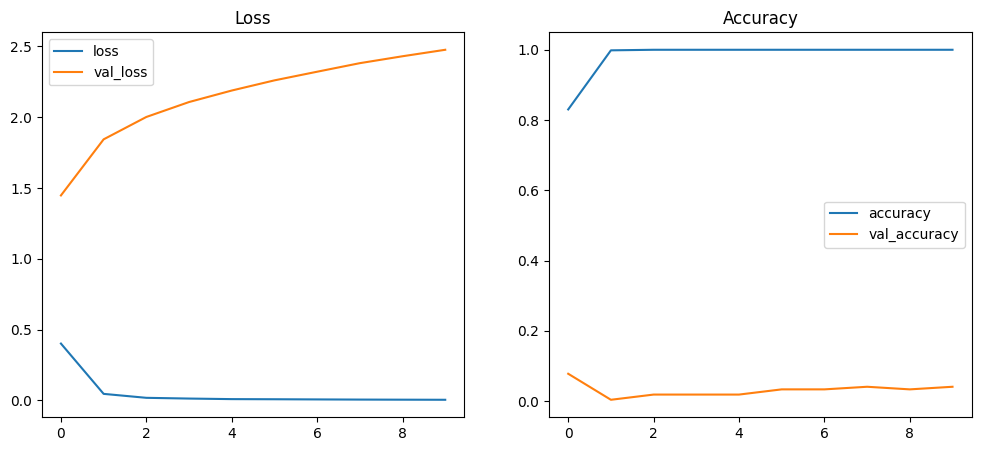

9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step
Confusion Matrix:
 [[66 84]
 [43 77]]


In [9]:
# Build and train the model
model = build_model()
train_gen, val_gen = create_datagen(output_base_dir)
model = train_model(model, train_gen, val_gen)
evaluate_model(model, val_gen)

In [10]:
model.save('/kaggle/working/violence_detection_resnet50.h5')

In [11]:
# Assuming 'history' is the variable holding the output from the model.fit call
final_train_accuracy = history.history['accuracy'][-1]  # Last training accuracy
final_val_accuracy = history.history['val_accuracy'][-1]  # Last validation accuracy

print(f"Final Training Accuracy: {final_train_accuracy*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy*100:.2f}%")

NameError: name 'history' is not defined

In [47]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model

def predict_violence_from_image(model, image_path_or_url):
    # Check if the input is a URL or a local file path
    if image_path_or_url.startswith('http://') or image_path_or_url.startswith('https://'):
        response = requests.get(image_path_or_url)
        img = load_img(BytesIO(response.content), target_size=(224, 224))
    else:
        img = load_img(image_path_or_url, target_size=(224, 224))

    # Preprocess the image
    img_array = img_to_array(img)  # Convert the image to a numpy array
    img_array = preprocess_input(img_array)  # Preprocess the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the violence probability
    prediction = model.predict(img_array)
    violence_probability = prediction[0][0]
    label = 'Violent' if violence_probability > 0.5 else 'Non-violent'

    # Return the loaded image, label, and the probability
    return img, label, violence_probability

In [ ]:
# Example usage
# video_path = '/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted/Test/Violence/t_v001_converted.avi'
# print(detect_violence(model, video_path))
# Example usage of the function
image_url = 'https://akm-img-a-in.tosshub.com/indiatoday/images/story/202104/crowd.jpg?size=690:388'
image, result, probability = predict_violence_from_image(model, image_url)

# Plot the image and label it with the prediction result and probability
plt.imshow(image)
plt.title(f'Prediction: {result}\nProbability: {probability:.2f}')
plt.axis('off')  # Hide the axes
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 2: Prepare your data
# Define the path to your validation data
validation_data_dir = '/kaggle/working/Test'  # Adjust this path

# Create a data generator for validation
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # Use the appropriate preprocess_input depending on your model base

# Create a data generator flow from the directory
val_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),  # Same size as your model input
    batch_size=32,           # Batch size (adjust as needed)
    class_mode='binary',     # 'binary' for binary labels, change if necessary
    shuffle=False            # No need to shuffle for evaluation
)

# Step 3: Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)

print(f"Validation Loss: {val_loss:.2f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model_inception = load_model('/kaggle/working/inceptionv3.h5', compile=False)  # Load without compiling

# Recompile the model properly
model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Step 2: Prepare your data
# Define the path to your validation data
validation_data_dir = '/kaggle/working/Test/'  # Adjust this path

# Create a data generator for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create a data generator flow from the directory
val_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),  # Same size as your model input
    batch_size=32,           # Batch size (adjust as needed)
    class_mode='binary',     # 'binary' for binary labels, change if necessary
    shuffle=False            # No need to shuffle for evaluation
)

# Step 3: Evaluate the model
val_loss, val_accuracy = model_inception.evaluate(val_generator)

print(f"Validation Loss: {val_loss:.2f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")